### Домашнее задание Transformers Training (50 баллов)

В этом домашнем задании требуется обучить несколько Transformer-based моделей в задаче машинного перевода. Для обучения можно воспользоваться текущим проектом, так и реализовать свой пайплайн обучения. Если будете использовать проект, теги **TODO** проекта отмечают, какие компоненты надо реализовать.
В ноутбуке нужно только отобразить результаты обучения и выводы. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Ваш код обучения нужно выложить на ваш github, в строке ниже дать ссылку на него. В первую очередь будут оцениваться результаты в ноутбуке, код нужен для проверки адекватности результатов.

Обучать модели до конца не нужно, только для демонстрации, что модель обучается и рабочая - снижение val_loss, рост bleu_score.

#### Сcылка на ваш github с проектом(вставить свой) - https://github.com/runnerup96/pytorch-machine-translation

Ноутбук с результатами выкладывать на ваш **google диск** курса.

### Данные

`
wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip
`

Модели нужно обучить на задаче перевода с английского на русский.

In [1]:
!wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip

--2024-06-08 00:03:42--  https://www.manythings.org/anki/rus-eng.zip
Распознаётся www.manythings.org (www.manythings.org)… 173.254.30.110
Подключение к www.manythings.org (www.manythings.org)|173.254.30.110|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 16305013 (16M) [application/zip]
Сохранение в: «rus-eng.zip.8»

rus-eng.zip.8       100%[===================>]  15.55M  5.07MB/s    за 3.1s    

2024-06-08 00:03:47 (5.07 MB/s) - «rus-eng.zip.8» сохранён [16305013/16305013]

Archive:  rus-eng.zip
replace rus.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
!pip install transformers --quiet
!pip install matplotlib --quiet


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import re
import numpy as np
import torch
import random
import matplotlib.pylab as plt

In [3]:
MATCH_REGEX = re.compile(r"[+-]?\b(\d+([.]\d*)?([eE][+-]?\d+)?|[.]\d+([eE][+-]?\d+)?)\b")

def get_values(string):
    result = dict()
    params = ['val_loss', 'train_loss', 'bleu_score']
    if "train_loss" in string:
        found_vals = [re_match[0] for re_match in re.findall(MATCH_REGEX, string)]
    
        if len(params) == len(found_vals):
            for name, val in zip(params, found_vals):
                result[name] = float(val)
    return result

def make_plot(train_loss_list, val_loss_list, val_bleu_list, header):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    
    ax1.plot(range(len(train_loss_list)), train_loss_list, label='train loss')
    ax1.plot(range(len(val_loss_list)), val_loss_list, label='val loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend()
    
    ax2.plot(range(len(val_bleu_list)), val_bleu_list, label='val bleu')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('BLEU')
    ax2.legend()
    
    fig.suptitle(header, fontsize=20)
    plt.show()

def set_seed(seed=42):
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Обучение Seq2seq Transformer модель(25 баллов)

Реализуйте Seq2seq Transformer. В качестве блока трансформера можно использовать https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html. В качестве токенизатора воспользуйтесь HuggingFace токенизатор для source/target языков - https://huggingface.co/docs/transformers/fast_tokenizers
В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов.

Не забудьте остальные элементы модели:
* Мы можем использовать 1 трансформер как энкодер - декодером будет выступать линейный слой.
* Обучите свой BPE токенизатор - https://huggingface.co/docs/transformers/fast_tokenizers
* Матрицу эмбеддингов токенов
* Матрицу позицонных эмбеддингов
* Линейный слой проекции в target словарь
* Функцию маскирования будущих состояний attention, так как модель авто-регрессионна
* Learning rate schedualer


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, размерность скрытого слоя, количетсво слоев
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [4]:
import sys
sys.path.insert(1, "./src")

In [5]:
import yaml
from models import trainer
from data.datamodule import DataManager
from txt_logger import TXTLogger
from models.seq2seq_transformer import Seq2SeqTransformer
from models.seq2seq_t5 import Seq2SeqT5

data_config = yaml.load(open("configs/data_config.yaml", 'r'), Loader=yaml.Loader)

data_manager = DataManager(data_config, DEVICE)
train_dataloader, val_dataloader = data_manager.prepare_data()
target_tokenizer = data_manager.target_tokenizer
model_config = yaml.load(open("configs/model_config.yaml", "r"), Loader=yaml.Loader)

model_config

Reading from file: 100%|████████████| 496059/496059 [00:02<00:00, 195844.01it/s]


{'embedding_size': 510,
 'dim_feedforward': 256,
 'hidden_size': 256,
 'n_heads_attention': 6,
 'n_encoders': 4,
 'n_decoders': 4,
 'learning_rate': 0.0001,
 'dropout': 0.1,
 'epoch_num': 30,
 'try_one_batch': False}

In [6]:
import yaml
from models import trainer
from txt_logger import TXTLogger
from data.datamodule import DataManager

from models.seq2seq_t5 import Seq2SeqT5
from models.seq2seq_transformer import Seq2SeqTransformer


data_config = yaml.load(open("configs/data_config.yaml", 'r'), Loader=yaml.Loader)

data_manager = DataManager(data_config, DEVICE)
train_dataloader, val_dataloader = data_manager.prepare_data()
target_tokenizer = data_manager.target_tokenizer
model_config = yaml.load(open("configs/model_config.yaml", "r"), Loader=yaml.Loader)


model_transformer = Seq2SeqTransformer(
    encoder_vocab_size=len(data_manager.source_tokenizer.word2index),
    decoder_vocab_size=len(data_manager.target_tokenizer.word2index),
    dim_feedforward=model_config['dim_feedforward'],
    lr=model_config['learning_rate'],
    device=DEVICE,
    target_tokenizer=target_tokenizer,
    T=model_config['epoch_num'] * len(train_dataloader),
    positional_embedding_size=model_config['embedding_size'],
    n_heads_attention=model_config['n_heads_attention'],
    n_encoders=model_config['n_encoders'],
    n_decoders=model_config['n_decoders'],
    dropout=model_config['dropout'],
)

logger = TXTLogger("training_logs_transformer")
trainer_transformer = trainer.Trainer(model=model_transformer, model_config=model_config, logger=logger)

if model_config['try_one_batch']:
    train_dataloader = [list(train_dataloader)[0]]
    val_dataloader = [list(val_dataloader)[0]]

trainer_transformer.train(train_dataloader, val_dataloader)

DATAPATH = 'training_logs_transformer'
progress_file_path = os.path.join(DATAPATH, "progress_log.txt")
file_content = open(progress_file_path, 'r').read().split("\n")


train_loss_list, val_loss_list, val_bleu_list = [], [], []
for line in file_content:
    d = get_values(line)
    if len(d) > 0:
        train_loss_list.append(d['train_loss'])
        val_loss_list.append(d['val_loss'])
        val_bleu_list.append(d['bleu_score'])



Reading from file: 100%|████████████| 496059/496059 [00:02<00:00, 188710.34it/s]


  3%|█▍                                          | 1/30 [00:01<00:55,  1.93s/it]

predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  66  353 2321   48   32   14  109  148   40    2    3]
words_actual:  ['он', 'занят', 'подготовкой', 'к', 'экзамену']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  66  964   94   97  470 1089  368    2    3    3    3]
words_actual:  ['он', 'высок', 'но', 'его', 'брат', 'намного', 'выше']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  68   74  148 1252  954  326  235  501    2    3    3]
words_actual:  ['она', 'не', 'менее', 'красива', 'чем', 'её', 'сестра']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  68   74  148 1252  954  326  235  501    2    3    3]
words_actual:  ['она', 'не', 'менее', 'красива', 'чем', 'её', 'сестра']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [ 68 545 250 802  45 326 746   2   3   3   3]
words_actual:  ['она', 'больше', 'знакомая', 'чем', 'подруга']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  [

  7%|██▉                                         | 2/30 [00:03<00:44,  1.59s/it]

predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  97  957  262  121  397   61 3484    2    3    3    3]
words_actual:  ['его', 'часто', 'путают', 'с', 'братом']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  68   61 4466   94  179  989   59 2298    2    3    3]
words_actual:  ['она', 'с', 'хоккайдо', 'но', 'сейчас', 'живёт', 'в', 'токио']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  66  341  248   74  730   48 4507 2086    2    3    3]
words_actual:  ['он', 'всё', 'ещё', 'не', 'привык', 'к', 'городской', 'жизни']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  66  119   59  106 1250  298  929    2    3    3    3]
words_actual:  ['он', 'ей', 'в', 'дедушки', 'годится']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
words_predicted:  []
actual:  [  68 2257  222   28  260  466  101   44   40 3497    2]
words_actual:  ['она', 'пользуется', 'большим', 'успехом', 'у', 'мальчиков']
predicted:  [3 3 3 3 3 3 3 3 3 3 3]
wo

 10%|████▍                                       | 3/30 [00:04<00:39,  1.47s/it]

predicted:  [66  3  3  3  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  68  278 3147  304 1965 2031    2    3    3    3    3]
words_actual:  ['она', 'слишком', 'мала', 'чтобы', 'знать', 'правду']
predicted:  [66  3  3  3  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66  824   50 4040 2158 1169    2    3    3    3    3]
words_actual:  ['он', 'женат', 'и', 'имеет', 'троих', 'детей']
predicted:  [66  3  3  3  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  68  105  122  115  572  103  232   59 3461    2    3]
words_actual:  ['она', 'очень', 'привередлива', 'в', 'еде']
predicted:  [66  3  3  3  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  68 1063  264  279 1585  302  264 2155   40  347    2]
words_actual:  ['она', 'только', 'что', 'из', 'университета', 'так', 'что', 'опыта', 'у', 'неё']
predicted:  [66  3  3  3  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66  325  474  856  304 1104   27  135  307   20    2]
words_actual:  ['он'

 13%|█████▊                                      | 4/30 [00:05<00:37,  1.42s/it]

predicted:  [66 66  2  3  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [  66  353 2321   48   32   14  109  148   40    2    3]
words_actual:  ['он', 'занят', 'подготовкой', 'к', 'экзамену']
predicted:  [66 66  2  3  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [  66   74  366   23   55   50  180  215  435 1827    2]
words_actual:  ['он', 'не', 'такой', 'уж', 'и', 'скряга', 'каким']
predicted:  [66 66  2  3  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [  68 3625   41 3069  105  954    2    3    3    3    3]
words_actual:  ['она', 'богата', 'а', 'также', 'очень', 'красива']
predicted:  [66 66  2  3  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [  68  159 1226  279  198  574  133   15   70   31    2]
words_actual:  ['она', 'всегда', 'жалуется', 'из', 'за', 'моей', 'малень']
predicted:  [66 66  2  3  3  3  3  3  3  3  3]
words_predicted:  ['он', 'он']
actual:  [  66 1397 3896 3591    2    3    3    3    3    3    3]
words_ac

 17%|███████▎                                    | 5/30 [00:07<00:35,  1.43s/it]

predicted:  [66  2  2  3  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66 4395  706   45    5   58   83  165 3041   36    2]
words_actual:  ['он', 'последний', 'кого', 'я', 'бы', 'попросил', 'о']
predicted:  [66  2  2  3  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66  100 2020  336 1187   67 1323  392  198 2210    2]
words_actual:  ['он', 'откладывает', 'деньги', 'на', 'поездку', 'за', 'границу']
predicted:  [66  2  2  3  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66  353 2321   48   32   14  109  148   40    2    3]
words_actual:  ['он', 'занят', 'подготовкой', 'к', 'экзамену']
predicted:  [66  2  2  3  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66  325  474  856  304 1104   27  135  307   20    2]
words_actual:  ['он', 'уже', 'достаточно', 'взрослый', 'чтобы', 'отличать', 'добр']
predicted:  [66  2  2  3  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  66 3052   67  264   85  513   39 1226    2    3    3]
words_actua

 20%|████████▊                                   | 6/30 [00:08<00:34,  1.43s/it]

predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [ 119   61 2282 2416  341   25  325    2    3    3    3]
words_actual:  ['ей', 'с', 'каждым', 'днём', 'всё', 'хуже']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  68   83  161   54 3618   59   83   20  281  320    2]
words_actual:  ['она', 'посол', 'франции', 'в', 'португа']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  68 4030   36  714  304  109  544 1099   67  583    2]
words_actual:  ['она', 'думает', 'о', 'том', 'чтобы', 'записаться', 'на', 'пар']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [ 68 747 109 148  12 237 172 499 359   2   3]
words_actual:  ['она', 'почти', 'заменила', 'ему', 'семью']
predicted:  [66  2  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он']
actual:  [  97  957  262  121  397   61 3484    2    3    3    3]
words_actual:  ['его', 'часто', 'путают', 'с', 'братом']
pred

 23%|██████████▎                                 | 7/30 [00:10<00:32,  1.41s/it]

predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  179  462   50   74  429   61 1947 4242    2    3]
words_actual:  ['она', 'сейчас', 'занята', 'и', 'не', 'может', 'с', 'вами', 'разговаривать']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  105 1424   50  325 3747  947   59 1213    2    3]
words_actual:  ['она', 'очень', 'больна', 'и', 'уже', 'неделю', 'лежит', 'в', 'постели']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66   74   15   70 2613   43   82  104   18   72    2]
words_actual:  ['он', 'не', 'лентяй', 'наоборо']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  474  665  304  161  106   20 1627  126   20    2]
words_actual:  ['он', 'достаточно', 'богат', 'чтобы', 'содержать', 'гор']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66   61 4107  726 1574   41  

 27%|███████████▋                                | 8/30 [00:11<00:30,  1.40s/it]

predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  329  299 1937  130 2381   73  795   59   86    2]
words_actual:  ['он', 'много', 'лет', 'представляет', 'нас', 'в', 'ко']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [ 235  221 1659   67 1950 1659   59 3106  339    2    3]
words_actual:  ['её', 'нет', 'ни', 'на', 'кухне', 'ни', 'в', 'гостиной']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  356 1252  161  162  152 2799  326  949 3352    2]
words_actual:  ['он', 'более', 'состоятелен', 'чем', 'был', 'десять']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [ 68 458 118 989 755 419 299   2   3   3   3]
words_actual:  ['она', 'вероятно', 'доживёт', 'до', 'ста', 'лет']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [ 66 951 940  10 173  67 180 717  37   2   3]
words_actual:  ['он',

 30%|█████████████▏                              | 9/30 [00:12<00:29,  1.39s/it]

predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68   74  148 1252  954  326  235  501    2    3    3]
words_actual:  ['она', 'не', 'менее', 'красива', 'чем', 'её', 'сестра']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [ 187 4672   66  957  465   59  596    2    3    3    3]
words_actual:  ['по', 'понедельникам', 'он', 'часто', 'опаздывает', 'в', 'школу']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  815 1251  167  305  264 1680  267 3603  264    2]
words_actual:  ['она', 'такая', 'доверчивая', 'что', 'поверит', 'всему', 'что']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [ 66  74 426  18 418  77  89  55  59  34   2]
words_actual:  ['он', 'не', 'самый', 'острый', 'нож', 'в', 'я']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  506  296 1504   83  195  223 2383   59   86

 33%|██████████████▎                            | 10/30 [00:14<00:27,  1.37s/it]

predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  59  323    5 1010   40   68 4385    5    4    5    2]
words_actual:  ['в', 'субботу', 'она', 'навестит', 'баб']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66 2213  109   83  309  911 4039    2    3    3    3]
words_actual:  ['он', 'плохо', 'запоминает', 'имена']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  231 1471   50  231  343   59  988    2    3    3]
words_actual:  ['он', 'хорошо', 'плавает', 'и', 'хорошо', 'играет', 'в', 'теннис']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66 2212  109   86   17 1735   27   78  135 3858    2]
words_actual:  ['он', 'скоро', 'закончит', 'читать', 'эту']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  654 2819  630 1796  430    2    3    3    3    3]
words_actual:  ['она', 'с

 37%|███████████████▊                           | 11/30 [00:15<00:26,  1.38s/it]

predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68   23   83 2582  562  255  103  883  304  100    2]
words_actual:  ['она', 'упорно', 'трудились', 'чтобы', 'от']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68   67  218 1659   90   20    6  496   21 1052    2]
words_actual:  ['она', 'на', 'грани', 'нервного', 'сры']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  537   19  111 1792  264  465    2    3    3    3]
words_actual:  ['она', 'торопится', 'потому', 'что', 'опаздывает']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  247  843   94  252   74 1209    2    3    3    3]
words_actual:  ['он', 'хороший', 'парень', 'но', 'мне', 'не', 'нравится']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  325   74  928 3769  432 1827  949 2891  139    2]
words_actual:  ['он',

 40%|█████████████████▏                         | 12/30 [00:17<00:25,  1.39s/it]

predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  325  278 1143  304  795  300  875   28  135    2]
words_actual:  ['он', 'уже', 'слишком', 'далеко', 'чтобы', 'нас', 'услышать']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66 4676 2140  660  985    2    3    3    3    3    3]
words_actual:  ['он', 'квалифицированный', 'преподаватель', 'английского', 'языка']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  641 1796  430    2    3    3    3    3    3    3]
words_actual:  ['она', 'учится', 'водить', 'машину']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  748  251 1017 4135    2    3    3    3    3    3]
words_actual:  ['она', 'постоянно', 'ко', 'всем', 'придирается']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  366 4004  264  205  375   37   97  241 1009    2]


 43%|██████████████████▋                        | 13/30 [00:18<00:23,  1.38s/it]

predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66 1046 1843   29 2753 2498   79 1035    2    3    3]
words_actual:  ['он', 'новообращённый', 'католик']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [ 66 511 318 169  59 771  30  10 498  59   2]
words_actual:  ['он', 'гораздо', 'лучше', 'меня', 'в', 'прыжках', 'в']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66 4645  144 2891 3008  647  529    2    3    3    3]
words_actual:  ['он', 'величайший', 'человек', 'когда', 'либо', 'живший']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66 1151 3983  326 3795    2    3    3    3    3    3]
words_actual:  ['он', 'скорее', 'критик', 'чем', 'романист']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68 2054  465   67 3705    2    3    3    3    3    3]
words_actual:  ['она', 'редко', 'о

 47%|████████████████████                       | 14/30 [00:19<00:22,  1.38s/it]

predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66 1151 3983  326 3795    2    3    3    3    3    3]
words_actual:  ['он', 'скорее', 'критик', 'чем', 'романист']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66 1403  183  204  198 1574   58   32   14 1356    2]
words_actual:  ['он', 'переживает', 'за', 'результаты', 'экзаме']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66 4395  144   61 2506   45 3785 4242    2    3    3]
words_actual:  ['он', 'последний', 'человек', 'с', 'кем', 'я', 'хочу', 'разговаривать']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [ 270  176  221  222   28   97 3416  326  165 1796    2]
words_actual:  ['для', 'него', 'нет', 'большего', 'счастья', 'чем', 'проводить']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  109  108   80    8   87    4   43 

 50%|█████████████████████▌                     | 15/30 [00:21<00:20,  1.37s/it]

predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  247  843   94  252   74 1209    2    3    3    3]
words_actual:  ['он', 'хороший', 'парень', 'но', 'мне', 'не', 'нравится']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  105  231  343   59 4529    2    3    3    3    3]
words_actual:  ['он', 'очень', 'хорошо', 'играет', 'в', 'бейсбол']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  179  462   50   74  429   61 1947 4242    2    3]
words_actual:  ['она', 'сейчас', 'занята', 'и', 'не', 'может', 'с', 'вами', 'разговаривать']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  742 1538  908    2    3    3    3    3    3    3]
words_actual:  ['она', 'привыкла', 'вставать', 'рано']
predicted:  [66 74  2  2  3  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [ 68 815 149 463 151 613   2   3   3   3   3]
wo

 53%|██████████████████████▉                    | 16/30 [00:22<00:19,  1.36s/it]

predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [ 68 159  82 312 447 831  67 454  19 103   2]
words_actual:  ['она', 'всегда', 'напрашивается', 'на', 'компли']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68 3274 2273 2585 1203   59  839    2    3    3    3]
words_actual:  ['она', 'самая', 'популярная', 'девочка', 'в', 'классе']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66 1167 1190   86  123  688 1403  358   30   54    2]
words_actual:  ['он', 'единственный', 'американец', 'который', 'переплыл']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66 1089  318  984   59  839    2    3    3    3    3]
words_actual:  ['он', 'намного', 'лучше', 'всех', 'в', 'классе']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  61  597 1906   66 1548  341  356 1252 1716   16    2]
words_actual:

 57%|████████████████████████▎                  | 17/30 [00:23<00:17,  1.36s/it]

predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66   74  159  317  187 2276    2    3    3    3    3]
words_actual:  ['он', 'не', 'всегда', 'дома', 'по', 'воскресеньям']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  159 2213  546 2100  540 1914    2    3    3    3]
words_actual:  ['он', 'всегда', 'плохо', 'говорит', 'про', 'свою', 'жену']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  606 2358   94   45  341  791   94   97  277    2]
words_actual:  ['он', 'грубый', 'но', 'я', 'всё', 'равно', 'его', 'люб']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  185 4322 4481    2    3    3    3    3    3    3]
words_actual:  ['она', 'боится', 'снова', 'заболеть']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68 2257  222   28  260  466  101   44   40 3497    2]
words_actu

 60%|█████████████████████████▊                 | 18/30 [00:25<00:16,  1.35s/it]

predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  730   48  712 1772 4650    2    3    3    3    3]
words_actual:  ['он', 'привык', 'к', 'такого', 'рода', 'ситуациям']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68   83  161   54 3618   59   83   20  281  320    2]
words_actual:  ['она', 'посол', 'франции', 'в', 'португа']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68 2057   97  310   90   28  497  109   20  658    2]
words_actual:  ['она', 'довольна', 'его', 'нынешней', 'зарплат']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68 1339  552   72  618   45  304  280 3154  570    2]
words_actual:  ['она', 'недостаточно', 'взрослая', 'чтобы', 'получить', 'вод']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  462 2321   48 2195    2    3    3    3    3    3]
words_act

 63%|███████████████████████████▏               | 19/30 [00:26<00:14,  1.35s/it]

predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68 3289 1761   41 1252  501  945    2    3    3    3]
words_actual:  ['она', 'пианистка', 'а', 'ее', 'сестра', 'певица']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  40  176  545  682   52  326   40  984 1670  136    2]
words_actual:  ['у', 'него', 'больше', 'книг', 'чем', 'у', 'всех', 'осталь']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [ 66 341 861 978 794 264 139 690  11 135   2]
words_actual:  ['он', 'всё', 'время', 'пытается', 'нам', 'что', 'то', 'сказать']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  97  741   74 1413   59 1555  187  445   71   44    2]
words_actual:  ['его', 'никогда', 'не', 'бывает', 'в', 'офисе', 'по', 'утрам']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  40  176 1027   83  250 1096 1013  207    

 67%|████████████████████████████▋              | 20/30 [00:27<00:13,  1.35s/it]

predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68 3228  111 3854  165  160    6 1742  541 1863    2]
words_actual:  ['она', 'числится', 'среди', 'пропавших', 'без', 'вести']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  742   74   21   19  135 1850 2917    2    3    3]
words_actual:  ['она', 'привыкла', 'не', 'спать', 'всю', 'ночь']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  675   10   67 3442   59 1440 3881    2    3    3]
words_actual:  ['она', 'должна', 'родить', 'в', 'этом', 'месяце']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66   74  928  144   61   86  123   20  695 1274    2]
words_actual:  ['он', 'не', 'тот', 'человек', 'с', 'которым', 'мы']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [ 68 172  74 501  41 613   2   3   3   3   3]
words_actual:  ['он

 70%|██████████████████████████████             | 21/30 [00:29<00:12,  1.35s/it]

predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  366 4004  264  205  375   37   97  241 1009    2]
words_actual:  ['он', 'такой', 'агрессивный', 'что', 'другие', 'его', 'избег']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  689 1308   67   61 1878 2029   85  119    2    3]
words_actual:  ['она', 'связана', 'с', 'той', 'компанией']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [ 68  74 348   5   4   5 288 146  68 348   2]
words_actual:  ['она', 'не', 'моя', 'бабушка', 'она', 'моя']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  325 3352 4487  774    2    3    3    3    3    3]
words_actual:  ['он', 'уже', 'десять', 'часов', 'спит']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  100 2020  336 1187   67 1323  392  198 2210    2]
words_actual:  ['он', 'откладывает',

 73%|███████████████████████████████▌           | 22/30 [00:30<00:10,  1.35s/it]

predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  68   74  148 1252  954  326  235  613    2    3    3]
words_actual:  ['она', 'не', 'менее', 'красива', 'чем', 'её', 'мать']
predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [172  74  83  11 752  70  36  83 760   8   2]
words_actual:  ['ему', 'не', 'позволено', 'покид']
predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  66 3596  984   59 1440 1370    2    3    3    3    3]
words_actual:  ['он', 'богаче', 'всех', 'в', 'этом', 'городе']
predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [ 834   66 2791 1041   59 2337   96  273    2    3    3]
words_actual:  ['говорят', 'он', 'родился', 'в', 'африке']
predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  59  323    5 1010   40   68 4385    5    4    5    2]
words_actual:  ['в', 'с

 77%|████████████████████████████████▉          | 23/30 [00:31<00:09,  1.35s/it]

predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66  407   82   12 3049   50   90 1050 2620    2    3]
words_actual:  ['он', 'молод', 'наивен', 'и', 'неопытен']
predicted:  [66 74  2  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  66 2009   94  989   59 3953    2    3    3    3    3]
words_actual:  ['он', 'англичанин', 'но', 'живёт', 'в', 'индии']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  40  176 2044 2454 1999   39    2    3    3    3    3]
words_actual:  ['у', 'него', 'серьёзная', 'болезнь']
predicted:  [66 74  2  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  404 1893  264  235 1479 3136  344 2699    2    3]
words_actual:  ['она', 'гордится', 'тем', 'что', 'её', 'сын', 'стал', 'врачом']
predicted:  [66 74  2  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не']
actual:  [  68  742   48 1843 1746   51   61  468  303   12    2]
words_actual:  ['она', '

 80%|██████████████████████████████████▍        | 24/30 [00:33<00:08,  1.35s/it]

predicted:  [66 74 67  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'на']
actual:  [  68  122  615  237   88   28  184   37 2756   98    2]
words_actual:  ['она', 'приняла', 'решение', 'стать', 'се']
predicted:  [66 74 67  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'на']
actual:  [  66  105 1186   83  327  442 1274  328  173 2190    2]
words_actual:  ['он', 'очень', 'честный', 'поэтому', 'мы', 'можем', 'положиться']
predicted:  [66 74 67  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'на']
actual:  [  66 1427  280 3154  492  328 1335 3155  198 3967    2]
words_actual:  ['он', 'жаждет', 'получить', 'возможность', 'учиться', 'за', 'границей']
predicted:  [66 74 67  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'на']
actual:  [  68  325 3098  134  120 2925   26  220    2    3    3]
words_actual:  ['она', 'уже', 'год', 'учит', 'немецкий']
predicted:  [66 74 67  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'на']
actual:  [ 68  74 302 954 151

 83%|███████████████████████████████████▊       | 25/30 [00:34<00:06,  1.35s/it]

predicted:  [66 74 59  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  66  278 4060  304   83  165    5 1318  264 3008    2]
words_actual:  ['он', 'слишком', 'осторожен', 'чтобы', 'попробовать', 'что', 'либо']
predicted:  [66 74 67  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'на']
actual:  [  68  105 1457  151   59 3693  302   50   59  605    2]
words_actual:  ['она', 'очень', 'известна', 'как', 'в', 'японии', 'так', 'и', 'в', 'аме']
predicted:  [66 74 59  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  66  105  241  148 2476   61 2845    8  176 1768    2]
words_actual:  ['он', 'очень', 'изменился', 'с', 'последнего', 'раза']
predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  68  156   82  251 3274 4454 2097  181    8   50    2]
words_actual:  ['она', 'однако', 'самая', 'очаровательная', 'молодая', 'леди']
predicted:  [66 74 59  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 

 87%|█████████████████████████████████████▎     | 26/30 [00:36<00:05,  1.35s/it]

predicted:  [66 74 74  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'не']
actual:  [  68   67 1685  299  543   97    2    3    3    3    3]
words_actual:  ['она', 'на', 'пять', 'лет', 'моложе', 'его']
predicted:  [66 74 74  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'не']
actual:  [  66  105 1764   17 1393   66  546  264   25  100    2]
words_actual:  ['он', 'очень', 'стеснителен', 'он', 'говорит', 'что', 'хот']
predicted:  [66 74 74  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'не']
actual:  [  68 1151  250  802   45  326  746    2    3    3    3]
words_actual:  ['она', 'скорее', 'знакомая', 'чем', 'подруга']
predicted:  [66 74 74  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'не']
actual:  [  68   67 1685  299  543  169    2    3    3    3    3]
words_actual:  ['она', 'на', 'пять', 'лет', 'моложе', 'меня']
predicted:  [66 74 74  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'не']
actual:  [  66  139  264 1274 1320  223  173  460   9

 90%|██████████████████████████████████████▋    | 27/30 [00:37<00:04,  1.35s/it]

predicted:  [66 74 59  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  68   59  226   28  173 1183   37 1018 3207  202    2]
words_actual:  ['она', 'в', 'лучшем', 'случае', 'второсортная']
predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  68  278  827  304  280 3154  570  381  180 1634    2]
words_actual:  ['она', 'слишком', 'молода', 'чтобы', 'получить', 'водительские']
predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  68  586 2217   59 3535    2    3    3    3    3    3]
words_actual:  ['она', 'делает', 'успехи', 'в', 'английском']
predicted:  [66 74 67  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'на']
actual:  [  66 2791 1041 1013 3618   94 1580   66 4572   21    2]
words_actual:  ['он', 'родился', 'во', 'франции', 'но', 'теперь', 'он', 'гражданин', 'с']
predicted:  [66 74 59  2  2  3  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  68  742 153

 93%|████████████████████████████████████████▏  | 28/30 [00:38<00:02,  1.35s/it]

predicted:  [66 74 67  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'на']
actual:  [  66  545   74 1737  700   97 4043    2    3    3    3]
words_actual:  ['он', 'больше', 'не', 'член', 'нашего', 'клуба']
predicted:  [66 74 59  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  68  711   67 1950   50 2562   73  113   43    2    3]
words_actual:  ['она', 'сидит', 'на', 'кухне', 'и', 'пьет', 'чай']
predicted:  [66 74 67  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'на']
actual:  [  66   74  928  144   61   86  123   20  695 1274    2]
words_actual:  ['он', 'не', 'тот', 'человек', 'с', 'которым', 'мы']
predicted:  [66 74 67  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'на']
actual:  [ 68 159  82 312 447 831  67 454  19 103   2]
words_actual:  ['она', 'всегда', 'напрашивается', 'на', 'компли']
predicted:  [66 74 67  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'на']
actual:  [ 68 545 250 802  45 326 746   2   3   3   3]
words_a

 97%|█████████████████████████████████████████▌ | 29/30 [00:40<00:01,  1.35s/it]

predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  68  978  118 4111  323   29    9  163 2808   37    2]
words_actual:  ['она', 'пытается', 'доказать', 'существование']
predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  68 1117   42  165  181  236  237   59 1943    2    3]
words_actual:  ['она', 'месяц', 'пролежала', 'в', 'больнице']
predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [ 68 172  74 501  41 613   2   3   3   3   3]
words_actual:  ['она', 'ему', 'не', 'сестра', 'а', 'мать']
predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  66  992   59  347   94  978  180 1052  415 3142    2]
words_actual:  ['он', 'влюблён', 'в', 'неё', 'но', 'пытается', 'скрыть', 'свои']
predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  66  159 4135   48 1936    2    3    3    3    3    3]


100%|███████████████████████████████████████████| 30/30 [00:41<00:00,  1.38s/it]

predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  68  654   83 2520  415 2240  434 2416    2    3    3]
words_actual:  ['она', 'собирается', 'помыть', 'велосипед', 'сегодня', 'днём']
predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  68  348 1885  250  802   45    2    3    3    3    3]
words_actual:  ['она', 'моя', 'старая', 'знакомая']
predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [ 66 748 997 282   2   3   3   3   3   3   3]
words_actual:  ['он', 'постоянно', 'командует']
predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  40  176 1027  636 1668  332  750   45  126   20    2]
words_actual:  ['у', 'него', 'есть', 'все', 'основания', 'гор']
predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [ 66  74 406  41 598 250  86 394   2   3   3]
words_actual:  ['он', 'не', 'друг'

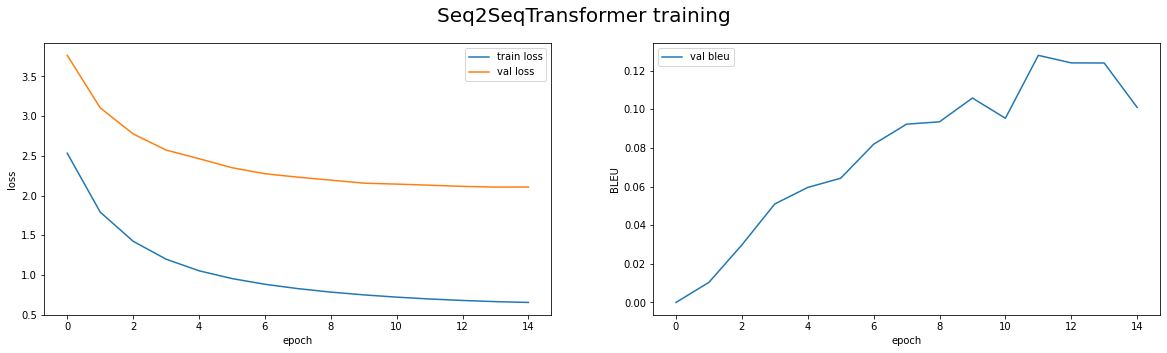

In [7]:
make_plot(train_loss_list, val_loss_list, val_bleu_list, header='Seq2SeqTransformer training')

In [13]:
model_transformer.eval()
for i, batch in enumerate(val_dataloader):
    feature, target = batch
    with torch.no_grad():
        feature = feature[:10]
        target = target[:10]
        feature = feature.to(DEVICE)
        target = target.to(DEVICE)

        predicted_samples, _ = model_transformer.forward(feature)
        bleu_score, actual_sentences, predicted_sentences = model_transformer.eval_bleu(predicted_samples, target)
    for orig, actual, pred in zip(feature, actual_sentences, predicted_sentences):
        print("Actual: ", actual, "\nPredicted: ", pred, "\n")
    break

predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  66  586 2310 2217   59 3535    2    3    3    3    3]
words_actual:  ['он', 'делает', 'большие', 'успехи', 'в', 'английском']
predicted:  [66 74 67  2  2  2  2  3  3  3  3]
words_predicted:  ['он', 'не', 'на']
actual:  [  68  585 4048   94   74  815  463    2    3    3    3]
words_actual:  ['она', 'умнее', 'мэри', 'но', 'не', 'такая', 'красивая']
predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  66  185  264  429 3920    2    3    3    3    3    3]
words_actual:  ['он', 'боится', 'что', 'может', 'опоздать']
predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  68 1737    5    4  180   99  222  496 4043    2    3]
words_actual:  ['она', 'член', 'баскетбольного', 'клуба']
predicted:  [66 74 59  2  2  2  3  3  3  3  3]
words_predicted:  ['он', 'не', 'в']
actual:  [  68  978   21  197   69  635   94   74 1963  1

### Fine-tune pretrained T5 (25 баллов)

Реализуйте Seq2seq Pretrained T5. Воспользуйтесь https://huggingface.co/docs/transformers/model_doc/t5 предобученной моделью. В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Не забудьте важные аспекты обучения модели:
* Взять готовый t5 токенизатор
* Resize matrix embedding - скорей всего ваша матрица эмбеддингов не будет включать эмбеддинги из вашего сета. Пример обновления матрицы эмбеддингов тут тут https://github.com/runnerup96/Transformers-Tuning/blob/main/t5_encoder_decoder.py
* Learning rate schedualer/Adafactor with constant learning rate


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, pretrained model name
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [1]:
import sys
sys.path.insert(1, "./src")
import yaml
from models import trainer
from models.seq2seq_t5 import Seq2SeqT5
from txt_logger import TXTLogger
from data.datamodule import DataManager

import os
import re
import numpy as np
import torch
import random
import matplotlib.pylab as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

data_config = yaml.load(open("configs/data_config.yaml", 'r'), Loader=yaml.Loader)
model_config = yaml.load(open("configs/model_config.yaml", "r"), Loader=yaml.Loader)

data_manager = DataManager(data_config, DEVICE)
train_dataloader, val_dataloader = data_manager.prepare_data()
target_tokenizer = data_manager.target_tokenizer

model = Seq2SeqT5(
    pretrained_name=model_config['pretrained_name'],
    encoder_vocab_size=len(data_manager.source_tokenizer.word2index),
    decoder_vocab_size=len(data_manager.target_tokenizer.word2index),
    lr=model_config['learning_rate'],
    target_tokenizer=target_tokenizer,
    device=DEVICE,
    T=model_config['epoch_num'] * len(train_dataloader),
    start_symbol=target_tokenizer.tokenizer.pad_token
)

logger = TXTLogger("training_log")
trainer = trainer.Trainer(model, model_config, logger)
trainer.train(train_dataloader, val_dataloader)

Reading from file: 100%|██████████| 496059/496059 [00:03<00:00, 147742.40it/s]
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added 

Last 0 epoch train loss:  214.92698734998703


UnboundLocalError: local variable 'val_epoch_loss' referenced before assignment

In [ ]:
DATAPATH = 'training_log_t5'
progress_file_path = os.path.join(DATAPATH, "progress_log.txt")
file_content = open(progress_file_path, 'r').read().split("\n")

train_loss_list, val_loss_list, val_bleu_list = [], [], []
for line in file_content:
    d = get_values(line)
    if len(d) > 0:
        train_loss_list.append(d['train_loss'])
        val_loss_list.append(d['val_loss'])
        val_bleu_list.append(d['bleu_score'])

make_plot(train_loss_list, val_loss_list, val_bleu_list, run_name='Seq2SeqT5 training')